In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel
#from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPointFull
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d
from src.gpu_metrics import run_bootstrap

In [2]:
!nvidia-smi

Fri Jul 12 13:46:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0              54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
rng = np.random.default_rng(23673)

In [5]:
L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS

k = NUM_ACCUMULATION_STEPS*k

CL = 2 * np.sum(AR*(W-1))

In [6]:
data_dir = '../Data'
setType = 'train'
annotation, transcriptToLabel, seqData = getData(data_dir, setType)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3166851/2404782504.py", line 3, in <module>
    annotation, transcriptToLabel, seqData = getData(data_dir, setType)
  File "/splice-site-prediction/Code/src/dataloader.py", line 65, in getData
    seqData[chrom] = load_npz(path).tocsr()
  File "/opt/conda/lib/python3.8/site-packages/scipy/sparse/_matrix_io.py", line 146, in load_npz
    return cls((loaded['data'], (loaded['row'], loaded['col'])), shape=loaded['shape'])
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py", line 254, in __getitem__
    return format.read_array(bytes,
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/format.py", line 779, in read_array
    data = _read_bytes(fp, read_size, "array data")
  File "/opt/conda/lib/python3.8/site-packages/numpy/lib/format.py", line 908, in _rea

TypeError: object of type 'NoneType' has no len()

In [6]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number
# Sequence length of SpliceAIs (SL+CL will be the input length and
# SL will be the output length)

SL=5000
CL_max=5000

In [7]:
assert CL_max % 2 == 0

In [9]:
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]

In [10]:
train_dataset = spliceDataset(getDataPointListFull(annotation_train,transcriptToLabel,SL,CL_max,shift=SL))
val_dataset = spliceDataset(getDataPointListFull(annotation_validation,transcriptToLabel,SL,CL_max,shift=SL))
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
hs = []
learning_rate= k*1e-3
gamma=0.5
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 

Epoch (train) 1/10: 100%|█████████████████████████████| 2716/2716 [42:16<00:00,  1.07it/s, a_r=0.87, d_r=0.884, loss=0.000217, r_a=0.998, r_d=0.982, r_loss=0.948]


epoch: 1/10, train loss = 0.015583


Epoch (train) 2/10: 100%|████████████████████████████| 2716/2716 [39:56<00:00,  1.13it/s, a_r=0.894, d_r=0.906, loss=0.000192, r_a=0.998, r_d=0.991, r_loss=0.769]


epoch: 2/10, train loss = 0.000199


Epoch (train) 3/10: 100%|██████████████████████████████| 2716/2716 [39:23<00:00,  1.15it/s, a_r=0.903, d_r=0.91, loss=0.00018, r_a=0.999, r_d=0.987, r_loss=0.642]


epoch: 3/10, train loss = 0.000178


Epoch (train) 4/10: 100%|████████████████████████████| 2716/2716 [39:29<00:00,  1.15it/s, a_r=0.915, d_r=0.924, loss=0.000157, r_a=0.999, r_d=0.989, r_loss=0.595]


epoch: 4/10, train loss = 0.000165


Epoch (train) 5/10: 100%|██████████████████████████████| 2716/2716 [39:45<00:00,  1.14it/s, a_r=0.926, d_r=0.934, loss=0.000148, r_a=0.999, r_d=0.981, r_loss=0.7]


epoch: 5/10, train loss = 0.000152


Epoch (train) 6/10: 100%|█████████████████████████████| 2716/2716 [39:10<00:00,  1.16it/s, a_r=0.935, d_r=0.94, loss=0.000136, r_a=0.999, r_d=0.981, r_loss=0.785]


epoch: 6/10, train loss = 0.000139


Epoch (train) 7/10: 100%|████████████████████████████| 2716/2716 [39:24<00:00,  1.15it/s, a_r=0.947, d_r=0.953, loss=0.000118, r_a=0.998, r_d=0.986, r_loss=0.706]


epoch: 7/10, train loss = 0.000111


Epoch (train) 8/10: 100%|█████████████████████████████| 2716/2716 [39:55<00:00,  1.13it/s, a_r=0.959, d_r=0.966, loss=8.87e-5, r_a=0.999, r_d=0.992, r_loss=0.546]


epoch: 8/10, train loss = 0.000093


Epoch (train) 9/10: 100%|██████████████████████████████| 2716/2716 [39:45<00:00,  1.14it/s, a_r=0.968, d_r=0.97, loss=7.89e-5, r_a=0.999, r_d=0.986, r_loss=0.597]


epoch: 9/10, train loss = 0.000080


Epoch (train) 10/10: 100%|████████████████████████████| 2716/2716 [38:48<00:00,  1.17it/s, a_r=0.969, d_r=0.973, loss=7.07e-5, r_a=0.999, r_d=0.988, r_loss=0.587]


epoch: 10/10, train loss = 0.000072


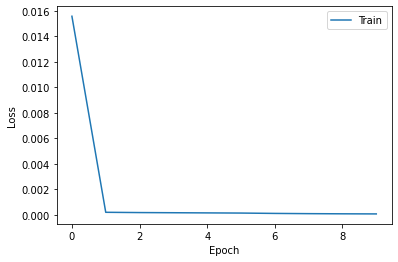

Epoch (train) 1/10: 100%|█████████████████████████████| 2716/2716 [38:42<00:00,  1.17it/s, a_r=0.868, d_r=0.886, loss=0.000213, r_a=0.997, r_d=0.996, r_loss=1.02]


epoch: 1/10, train loss = 0.016443


Epoch (train) 2/10: 100%|████████████████████████████| 2716/2716 [39:00<00:00,  1.16it/s, a_r=0.895, d_r=0.908, loss=0.000183, r_a=0.998, r_d=0.998, r_loss=0.843]


epoch: 2/10, train loss = 0.000194


Epoch (train) 3/10: 100%|████████████████████████████| 2716/2716 [39:27<00:00,  1.15it/s, a_r=0.909, d_r=0.914, loss=0.000177, r_a=0.998, r_d=0.998, r_loss=0.619]


epoch: 3/10, train loss = 0.000173


Epoch (train) 4/10:  49%|█████████████▌              | 1320/2716 [19:25<21:24,  1.09it/s, a_r=0.916, d_r=0.921, loss=0.000164, r_a=0.999, r_d=0.999, r_loss=0.601]

In [ ]:
for model_nr in range(10):
    model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    modelFileName = '../Results/PyTorch_Models/transformer_encoder_10k_090724_{}'.format(model_nr)
    loss = categorical_crossentropy_2d().loss
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)
    h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max)
    hs.append(h)

    plt.plot(range(epochs),h['loss'],label='Train')
    #plt.plot(range(epochs),h['val_loss'],label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/SpliceAITrainingCode/dataset_test_0_10k.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_10k_090724_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs))
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs[:,:,CL_max//2:-CL_max//2].unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:39<00:00, 13.74s/it]


In [19]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00018911732415244895

Acceptor:
0.9962	0.9498	0.9868	0.9909	0.977	0.9777	0.3228	0.0026	0.0004	13572	14289.0	14289

Donor:
0.995	0.9531	0.9895	0.9924	0.9794	0.9789	0.3274	0.0021	0.0003	13619	14289.0	14289


In [20]:
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
run_bootstrap(Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,n_bootstraps = 1000)

0.95146616278256 0.978190153837204


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:20<00:00,  4.99it/s]

average precision score = 0.978190153837204 (95% confidence interval: [0.9767384931445122, 0.9795814752578735])
topk score = 0.95146616278256 (95% confidence interval: [0.9496711785022705, 0.953234727457985])


In [8]:
setType = 'test'
data_dir = '../Data'
annotation_test, transcriptToLabel_test, seqData = getData(data_dir, setType)    

In [12]:
BATCH_SIZE = 16*8*8

In [13]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_10k_090724_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [31:49<00:00, 14.69s/it]


In [14]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00010955187279639043

Acceptor:
0.9805	0.9385	0.9913	0.9956	0.9635	0.9796	0.4549	0.0027	0.0004	84193	89712.0	89712

Donor:
0.9816	0.9433	0.9941	0.9971	0.9684	0.9804	0.4851	0.0021	0.0003	84624	89712.0	89712


In [15]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_10k_test_set_predictions_090724.csv.gz',index=False)

In [3]:
df = pd.read_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_10k_test_set_predictions_090724.csv.gz')
run_bootstrap(df['Y_true_acceptor'].astype(np.int8),df['Y_pred_acceptor'].astype(np.float32),df['Y_true_donor'].astype(np.int8),df['Y_pred_donor'].astype(np.float32),n_bootstraps = 1000)

0.9408830479757446 0.9659759998321533


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [32:37<00:00,  1.96s/it]

average precision score = 0.9659759998321533 (95% confidence interval: [0.9648173242807389, 0.9665709853172302])
topk score = 0.9408830479757446 (95% confidence interval: [0.9399479672451853, 0.9415226325095927])
